# PSEUDo vs. PEAX

In this experiment we will compare the LSH algorithm of PSEUDo to PEAX. The metrics we will be comparing these two algorithms with are **computing time**, **recall** and **precision**.

In [7]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

We first load the EEG data and convert it to a numpy array

In [1]:
import numpy as np
import json
import h5py
import os
import sys
from time import time
import warnings

# Ignore warnings as they just pollute the output
warnings.filterwarnings('ignore')

# Enable importing modules from the parent directory
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
module_path = os.path.abspath(os.path.join('../experiments'))
if module_path not in sys.path:
    sys.path.append(module_path)

# DNase-seq 2011, hg19
bw = 'data/ENCFF158GBQ.bigWig'

In [2]:
from download import download_encode_file, download_file
from pathlib import Path

Path('data').mkdir(parents=True, exist_ok=True)
Path('models').mkdir(parents=True, exist_ok=True)

download_encode_file('ENCFF158GBQ.bigWig')

download_file(
    "https://zenodo.org/record/2609763/files/dnase_w-12000_r-100.h5?download=1",
    "dnase_w-12000_r-100.h5",
    dir="models"
)

./data/ENCFF158GBQ.bigWig already exist. To overwrite pass `overwrite=True`
./models/dnase_w-12000_r-100.h5 already exist. To overwrite pass `overwrite=True`


In [12]:
import bigwig

t0 = time()
data_12kb = np.array(bigwig.chunk(bw, 12000, 100, 12000 / 6, ['chr1'], verbose=True), dtype="float32")

print('Done! Took {:.2f} seconds ({:.1f} minutes).'.format(time() - t0, (time() - t0) / 60))

Extracted 124621 windows from chr1 with a max value of 1.0.
Done! Took 26.01 seconds (0.4 minutes).


In [17]:
from utils import plot_windows_from_data

k_12kb = 20 # Number of KNNs to be saved later on
targets_12kb = [80503, 43895, 33430, 42575, 6112, 91938, 82896, 1060, 11975]
targets_12kb_ex = 12933

# print(data_12kb[0])

print(data_12kb.shape)

# plot_windows_from_data(data_12kb, window_ids=targets_12kb)

(124621, 120)


Next, the data is cut into subwindows of size T. We use a stepsize of T/8. Because of memory issues, only 40 of the 70 channels are used for this experiment.

In [18]:
from sklearn import preprocessing

data = np.array([preprocessing.minmax_scale(i) for i in data_12kb])
print(data.shape)

(124621, 120)


We sample a number of subwindows which will be used as query for the search algorithms

In [19]:
print(data[0])

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         

## SAX

In [4]:
from tslearn.piecewise import SymbolicAggregateApproximation

t0 = time()
sax = SymbolicAggregateApproximation(n_segments=T, alphabet_size_avg=10)
sax_data = sax.fit_transform(data)
print('Done! Took {:.2f} seconds ({:.1f} minutes).'.format(time() - t0, (time() - t0) / 60))
sax_preprocess_time = time() - t0

Done! Took 83.42 seconds (1.4 minutes).


In [5]:
t0 = time()
all_sax_candidates = []
for i, target in enumerate(targets):
    t1 = time()
    query = sax_data[target]
    sax_distances = [np.linalg.norm(query - window) for window in sax_data]
    print('Target #{} done! Took {:.2f} seconds ({:.1f} minutes).'.format(i, time() - t1, (time() - t1) / 60))
    sax_candidates = sorted(range(len(sax_distances)), key=lambda k: sax_distances[k])
    all_sax_candidates.append(sax_candidates)
sax_time = time() - t0

Target #0 done! Took 1.94 seconds (0.0 minutes).
Target #1 done! Took 2.76 seconds (0.0 minutes).
Target #2 done! Took 2.42 seconds (0.0 minutes).
Target #3 done! Took 2.38 seconds (0.0 minutes).
Target #4 done! Took 2.48 seconds (0.0 minutes).
Target #5 done! Took 2.48 seconds (0.0 minutes).
Target #6 done! Took 2.54 seconds (0.0 minutes).
Target #7 done! Took 2.47 seconds (0.0 minutes).
Target #8 done! Took 2.42 seconds (0.0 minutes).
Target #9 done! Took 2.20 seconds (0.0 minutes).


## PSEUDo

For the LSH algorithm some preprocessing is done to find the right LSH parameters.

In [6]:
import sys

sys.path.insert(0, '../Flaskserver')
import importlib
from pseudo import preprocess
import _lsh

topk_dtw = []

print('Preprocessing:')
t0 = time()
r,a,sd = preprocess(data, data.shape[2])
print('Preprocessing done. Took {:.2f} seconds ({:.1f} minutes).'.format(time() - t0, (time() - t0) / 60))
pseudo_preprocess_time = time()-t0

Preprocessing:
r = 16
r = 8.0
r = 12.0
r = 6.0
r = 9.0
Mean: 9.071967726705571
Stdev: 0.28006735776530695
Ratio mean: 0.9525575958004631
Ratio stdev: 0.021344448152730445
Theta: 8.34939394367108
r: 0.8184934917062332
Preprocessing time: 11.38901424407959
Preprocessing done. Took 11.39 seconds (0.2 minutes).


Now we run the LSH algorithm for all targets and calculate the most similar subwindows

In [7]:
from collections import defaultdict
t0 = time()
total_lsh_times = []
all_lsh_candidates = []
for i, target in enumerate(targets):
    t1 = time()
    query = data[target]
    print('doing lsh')
    lsh_candidates, lsh_distances, _ = _lsh.lsh(data, query, r, a, sd, 0)
#     topk_dtw.append(candidates)
    dict = defaultdict(int)
    for l in range(len(lsh_candidates)):
        for k in range(len(lsh_candidates[0])):
            for a in range(len(lsh_candidates[0][0])):
                dict[lsh_candidates[l][k][a]] += lsh_distances[l][k][a]
    sorted_dict = {k: v for k, v in sorted(dict.items(), key=lambda item: item[1])}
    candidates = list(sorted_dict.keys())
    total_lsh_times.append(time()-t1)
    print('Target #{} done! Took {:.2f} seconds ({:.1f} minutes).'.format(i, time() - t1, (time() - t1) / 60))
    all_lsh_candidates.append(candidates)
    
# print(candidates[0:10])
print('Done! Took {:.2f} seconds ({:.1f} minutes).'.format(time() - t0, (time() - t0) / 60))

doing lsh
Target #0 done! Took 14.48 seconds (0.2 minutes).
doing lsh
Target #1 done! Took 14.72 seconds (0.2 minutes).
doing lsh
Target #2 done! Took 14.28 seconds (0.2 minutes).
doing lsh
Target #3 done! Took 15.02 seconds (0.3 minutes).
doing lsh
Target #4 done! Took 16.06 seconds (0.3 minutes).
doing lsh
Target #5 done! Took 16.49 seconds (0.3 minutes).
doing lsh
Target #6 done! Took 16.28 seconds (0.3 minutes).
doing lsh
Target #7 done! Took 14.95 seconds (0.2 minutes).
doing lsh
Target #8 done! Took 9.91 seconds (0.2 minutes).
doing lsh
Target #9 done! Took 9.16 seconds (0.2 minutes).
Done! Took 141.36 seconds (2.4 minutes).


In [8]:
from collections import defaultdict
t0 = time()
total_lsh_times_ed = []
all_lsh_candidates_ed = []
for i, target in enumerate(targets):
    t1 = time()
    query = data[target]
    print('doing lsh')
    lsh_candidates, lsh_distances, _ = _lsh.lsh(data, query, r, a, sd, 1)
#     topk_dtw.append(candidates)
    dict = defaultdict(int)
    for l in range(len(lsh_candidates)):
        for k in range(len(lsh_candidates[0])):
            for a in range(len(lsh_candidates[0][0])):
                dict[lsh_candidates[l][k][a]] += lsh_distances[l][k][a]
    sorted_dict = {k: v for k, v in sorted(dict.items(), key=lambda item: item[1])}
    candidates = list(sorted_dict.keys())
    total_lsh_times_ed.append(time()-t1)
    print('Target #{} done! Took {:.2f} seconds ({:.1f} minutes).'.format(i, time() - t1, (time() - t1) / 60))
    all_lsh_candidates_ed.append(candidates)
    
# print(candidates[0:10])
print('Done! Took {:.2f} seconds ({:.1f} minutes).'.format(time() - t0, (time() - t0) / 60))

doing lsh
Target #0 done! Took 6.39 seconds (0.1 minutes).
doing lsh
Target #1 done! Took 8.50 seconds (0.1 minutes).
doing lsh
Target #2 done! Took 8.63 seconds (0.1 minutes).
doing lsh
Target #3 done! Took 6.42 seconds (0.1 minutes).
doing lsh
Target #4 done! Took 7.78 seconds (0.1 minutes).
doing lsh
Target #5 done! Took 8.60 seconds (0.1 minutes).
doing lsh
Target #6 done! Took 8.76 seconds (0.1 minutes).
doing lsh
Target #7 done! Took 4.78 seconds (0.1 minutes).
doing lsh
Target #8 done! Took 8.41 seconds (0.1 minutes).
doing lsh
Target #9 done! Took 8.61 seconds (0.1 minutes).
Done! Took 76.89 seconds (1.3 minutes).


## DTW

In [9]:
from scipy.spatial.distance import cdist
from tslearn.metrics import dtw_path_from_metric
from tslearn.metrics import dtw
from time import time

t0 = time()
total_dtw_times = []
all_dtw_candidates = []
for i, target in enumerate(targets):
    t1 = time()
    query = data[target]
    dtw_distances = [dtw(window, query, global_constraint='sakoe_chiba', sakoe_chiba_radius=int(0.05 * T)) for window in data]
    dtw_candidates = sorted(range(len(dtw_distances)), key=lambda k: dtw_distances[k])
    print('Target #{} done! Took {:.2f} seconds ({:.1f} minutes).'.format(i, time() - t1, (time() - t1) / 60))
    total_dtw_times.append(time()-t1)
    all_dtw_candidates.append(dtw_candidates)
print('Done! Took {:.2f} seconds ({:.1f} minutes).'.format(time() - t0, (time() - t0) / 60))

Target #0 done! Took 9.00 seconds (0.1 minutes).
Target #1 done! Took 8.90 seconds (0.1 minutes).
Target #2 done! Took 8.93 seconds (0.1 minutes).
Target #3 done! Took 8.76 seconds (0.1 minutes).
Target #4 done! Took 8.79 seconds (0.1 minutes).
Target #5 done! Took 8.78 seconds (0.1 minutes).
Target #6 done! Took 8.79 seconds (0.1 minutes).
Target #7 done! Took 8.78 seconds (0.1 minutes).
Target #8 done! Took 8.85 seconds (0.1 minutes).
Target #9 done! Took 8.84 seconds (0.1 minutes).
Done! Took 88.42 seconds (1.5 minutes).


## ED

In [10]:
t0 = time()
all_ed_candidates = []
total_ed_times = []
for i, target in enumerate(targets):
    t1 = time()
    query = data[target]
    ed_distances = [np.linalg.norm(query-window) for window in data]
    print('Target #{} done! Took {:.2f} seconds ({:.1f} minutes).'.format(i, time() - t1, (time() - t1) / 60))
    ed_candidates = sorted(range(len(ed_distances)), key=lambda k: ed_distances[k])
    total_ed_times.append(time()-t1)
    all_ed_candidates.append(ed_candidates)
print('Done! Took {:.2f} seconds ({:.1f} minutes).'.format(time() - t0, (time() - t0) / 60))

Target #0 done! Took 1.19 seconds (0.0 minutes).
Target #1 done! Took 1.19 seconds (0.0 minutes).
Target #2 done! Took 1.23 seconds (0.0 minutes).
Target #3 done! Took 1.29 seconds (0.0 minutes).
Target #4 done! Took 1.32 seconds (0.0 minutes).
Target #5 done! Took 1.22 seconds (0.0 minutes).
Target #6 done! Took 1.20 seconds (0.0 minutes).
Target #7 done! Took 1.21 seconds (0.0 minutes).
Target #8 done! Took 1.21 seconds (0.0 minutes).
Target #9 done! Took 1.21 seconds (0.0 minutes).
Done! Took 13.54 seconds (0.2 minutes).


## Accuracy comparison

We compare the PSEUDo candidates to the DTW candidates and test on recall, precision and number of pruned candidates

In [11]:
k = 100
total_recall_pseudo = []
total_precision_pseudo = []
total_precision2_pseudo = []
total_pruned_pseudo = []
for i in range(len(targets)):
    top_10_percent = int(len(all_lsh_candidates[i]) * 0.1)
    pruned = int(100*(1-len(all_lsh_candidates[i])/len(all_dtw_candidates[i])))
#     print("Pruned: " + str(pruned) + "%")
    recall = 0
    for index in all_dtw_candidates[i][0:k]:
        if index in all_lsh_candidates[i]:
            recall += 1
#     print("Recall: " + str(100*recall/k) + "%")

    precision = 0
    for index in all_dtw_candidates[i][0:k]:
        if index in all_lsh_candidates[i][0:k]:
            precision += 1
#     print("Precision: " + str(100*precision/k) + "%")
    
    precision2 = 0
    for index in all_lsh_candidates[i][0:k]:
        if index in all_dtw_candidates[i][0:top_10_percent]:
            precision2 += 1
#     print("Precision 10th percentile: " + str(100*precision2/k) + "%")
    total_pruned_pseudo.append(pruned)
    total_recall_pseudo.append(recall/k)
    total_precision_pseudo.append(precision/k)
    total_precision2_pseudo.append(precision2/k)
    
print("=================================================")
print("Total pruned: " + str(np.mean(total_pruned_pseudo)) + "%")
print("Total recall: " + str(100 * np.mean(total_recall_pseudo)) + "%")
print("Total precision: " + str(100 * np.mean(total_precision_pseudo)) + "%")
print("Total precision 2: " + str(100 *np.mean(total_precision2_pseudo)) + "%")

Total pruned: 7.9%
Total recall: 96.30000000000001%
Total precision: 11.700000000000003%
Total precision 2: 77.50000000000001%


In [12]:
total_recall_pseudo_ed = []
total_precision_pseudo_ed = []
total_precision2_pseudo_ed = []
total_pruned_pseudo_ed = []
for i in range(len(targets)):
    top_10_percent = int(len(all_lsh_candidates_ed[i]) * 0.1)
    pruned = int(100*(1-len(all_lsh_candidates_ed[i])/len(all_dtw_candidates[i])))
#     print("Pruned: " + str(pruned) + "%")
    recall = 0
    for index in all_dtw_candidates[i][0:k]:
        if index in all_lsh_candidates_ed[i]:
            recall += 1
#     print("Recall: " + str(100*recall/k) + "%")

    precision = 0
    for index in all_dtw_candidates[i][0:k]:
        if index in all_lsh_candidates_ed[i][0:k]:
            precision += 1
#     print("Precision: " + str(100*precision/k) + "%")
    
    precision2 = 0
    for index in all_lsh_candidates_ed[i][0:k]:
        if index in all_dtw_candidates[i][0:top_10_percent]:
            precision2 += 1
#     print("Precision 10th percentile: " + str(100*precision2/k) + "%")
    total_pruned_pseudo_ed.append(pruned)
    total_recall_pseudo_ed.append(recall/k)
    total_precision_pseudo_ed.append(precision/k)
    total_precision2_pseudo_ed.append(precision2/k)
    
print("=================================================")
print("Total pruned: " + str(np.mean(total_pruned_pseudo_ed)) + "%")
print("Total recall: " + str(100 * np.mean(total_recall_pseudo_ed)) + "%")
print("Total precision: " + str(100 * np.mean(total_precision_pseudo_ed)) + "%")
print("Total precision 2: " + str(100 *np.mean(total_precision2_pseudo_ed)) + "%")

Total pruned: 13.4%
Total recall: 94.60000000000001%
Total precision: 10.4%
Total precision 2: 75.69999999999999%


For validation we also test the recall and precision of the ED candidates copmared to the DTW candidates

In [13]:
total_recall_ed = []
total_precision_ed = []
total_precision2_ed = []
total_pruned_ed = []
for i in range(len(targets)):
    top_10_percent = int(len(all_ed_candidates[i]) * 0.1)
    pruned = int(100*(1-len(all_ed_candidates[i])/len(all_dtw_candidates[i])))
#     print("Pruned: " + str(pruned) + "%")
    recall = 0
    for index in all_dtw_candidates[i][0:k]:
        if index in all_ed_candidates[i]:
            recall += 1
#     print("Recall: " + str(100*recall/k) + "%")

    precision = 0
    for index in all_dtw_candidates[i][0:k]:
        if index in all_ed_candidates[i][0:k]:
            precision += 1
#     print("Precision: " + str(100*precision/k) + "%")
    
    precision2 = 0
    for index in all_ed_candidates[i][0:k]:
        if index in all_dtw_candidates[i][0:top_10_percent]:
            precision2 += 1
#     print("Precision 10th percentile: " + str(100*precision2/k) + "%")
    total_pruned_ed.append(pruned)
    total_recall_ed.append(recall/k)
    total_precision_ed.append(precision/k)
    total_precision2_ed.append(precision2/k)
    
print("=================================================")
print("Total pruned: " + str(np.mean(total_pruned_ed)) + "%")
print("Total recall: " + str(100 * np.mean(total_recall_ed)) + "%")
print("Total precision: " + str(100 * np.mean(total_precision_ed)) + "%")
print("Total precision 2: " + str(100 *np.mean(total_precision2_ed)) + "%")

Total pruned: 0.0%
Total recall: 100.0%
Total precision: 25.8%
Total precision 2: 100.0%


In [14]:
total_recall_sax = []
total_precision_sax = []
total_precision2_sax = []
total_pruned_sax = []
for i in range(len(targets)):
    top_10_percent = int(len(all_sax_candidates[i]) * 0.1)
    pruned = int(100*(1-len(all_sax_candidates[i])/len(all_dtw_candidates[i])))
#     print("Pruned: " + str(pruned) + "%")
    recall = 0
    for index in all_dtw_candidates[i][0:k]:
        if index in all_sax_candidates[i]:
            recall += 1
#     print("Recall: " + str(100*recall/k) + "%")

    precision = 0
    for index in all_dtw_candidates[i][0:k]:
        if index in all_sax_candidates[i][0:k]:
            precision += 1
#     print("Precision: " + str(100*precision/k) + "%")
    
    precision2 = 0
    for index in all_sax_candidates[i][0:k]:
        if index in all_dtw_candidates[i][0:top_10_percent]:
            precision2 += 1
#     print("Precision 10th percentile: " + str(100*precision2/k) + "%")
    total_pruned_sax.append(pruned)
    total_recall_sax.append(recall/k)
    total_precision_sax.append(precision/k)
    total_precision2_sax.append(precision2/k)
    
print("=================================================")
print("Total pruned: " + str(np.mean(total_pruned_sax)) + "%")
print("Total recall: " + str(100 * np.mean(total_recall_sax)) + "%")
print("Total precision: " + str(100 * np.mean(total_precision_sax)) + "%")
print("Total precision 2: " + str(100 *np.mean(total_precision2_sax)) + "%")

Total pruned: 0.0%
Total recall: 100.0%
Total precision: 20.0%
Total precision 2: 98.9%


Here we plot the results of the precision and recall

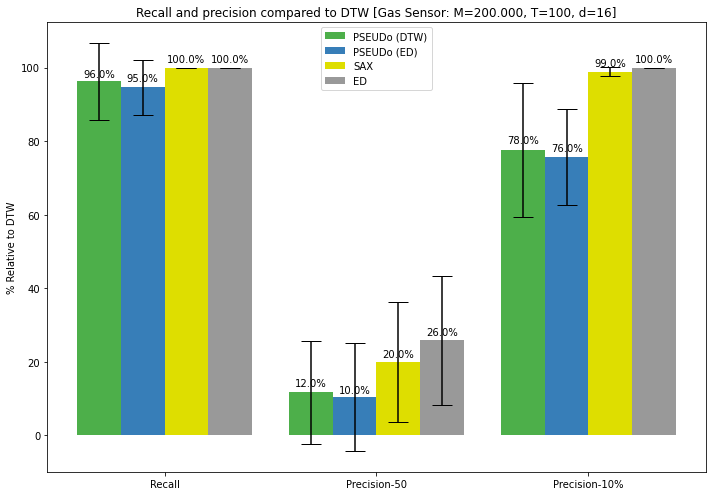

In [15]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

labels = ['Recall', 'Precision-50', 'Precision-10%']
pseudo_values = [
    100 * np.mean(total_recall_pseudo), 
    100 * np.mean(total_precision_pseudo), 
    100 * np.mean(total_precision2_pseudo)
]
pseudo_error = [
    100 * np.std(total_recall_pseudo), 
    100 * np.std(total_precision_pseudo), 
    100 * np.std(total_precision2_pseudo)
]
pseudo_ed_values = [
    100 * np.mean(total_recall_pseudo_ed), 
    100 * np.mean(total_precision_pseudo_ed), 
    100 * np.mean(total_precision2_pseudo_ed)
]
pseudo_ed_error = [
    100 * np.std(total_recall_pseudo_ed), 
    100 * np.std(total_precision_pseudo_ed), 
    100 * np.std(total_precision2_pseudo_ed)
]
ed_values = [
    100 * np.mean(total_recall_ed), 
    100 * np.mean(total_precision_ed), 
    100 * np.mean(total_precision2_ed)
]
ed_error = [
    100 * np.std(total_recall_ed), 
    100 * np.std(total_precision_ed), 
    100 * np.std(total_precision2_ed)
]
sax_values = [
    100 * np.mean(total_recall_sax), 
    100 * np.mean(total_precision_sax), 
    100 * np.mean(total_precision2_sax)
]
sax_error = [
    100 * np.std(total_recall_sax), 
    100 * np.std(total_precision_sax), 
    100 * np.std(total_precision2_sax)
]

colors = ['#4daf4a', '#377eb8', '#ff7f00',
          '#f781bf', '#a65628', '#984ea3',
          '#999999', '#e41a1c', '#dede00']

x = 1.7 * np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
fig.set_size_inches(10, 7)
rects1 = ax.bar(x - width * 1.5, pseudo_values, width, yerr=pseudo_error, color=colors[0], capsize=10, label='PSEUDo (DTW)')
rects2 = ax.bar(x - width * 0.5, pseudo_ed_values, width, yerr=pseudo_ed_error, color=colors[1], capsize=10, label='PSEUDo (ED)')
rects3 = ax.bar(x + width * 0.5, sax_values, width, yerr=sax_error,  color=colors[8], capsize=10, label='SAX')
rects4 = ax.bar(x + width * 1.5, ed_values, width, yerr=ed_error, color=colors[6], capsize=10, label='ED')

ax.set_ylabel('% Relative to DTW')
ax.set_title('Recall and precision compared to DTW [Gas Sensor: M=200.000, T=100, d=16]')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = round(rect.get_height(),0)
        ax.annotate('{}'.format(height)+'%',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)

fig.tight_layout()
plt.savefig('images/accuracy_gas_' + str(M) + '_' + str(T) +'_' + str(N))
plt.show()

## Computing time

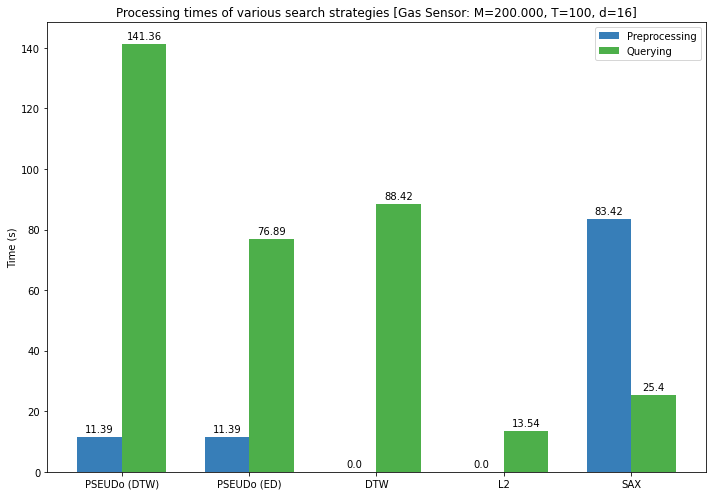

In [16]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np


labels = ['PSEUDo (DTW)', 'PSEUDo (ED)', 'DTW', 'L2', 'SAX']
preprocess_vales = [pseudo_preprocess_time, pseudo_preprocess_time, 0, 0, sax_preprocess_time]
query_values = np.array([np.sum(total_lsh_times), np.sum(total_lsh_times_ed), np.sum(total_dtw_times), np.sum(total_ed_times), sax_time])

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()
fig.set_size_inches(10, 7)
rects1 = ax.bar(x - width/2, preprocess_vales, width, color=colors[1], label='Preprocessing')
rects2 = ax.bar(x + width/2, query_values, width, color=colors[0], label='Querying')

ax.set_ylabel('Time (s)')
ax.set_title('Processing times of various search strategies [Gas Sensor: M=200.000, T=100, d=16]')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = round(rect.get_height(),2)
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.savefig('images/time_gas_' + str(M) + '_' + str(T) +'_' + str(N))

plt.show()